In [7]:
import time
import random
import matplotlib.pyplot as plt 
import matplotlib.patches as patches
import uuid
import pandas as pd
import numpy as np

In [2]:
#reference: https://jrtechs.net/data-science/implementing-a-quadtree-in-python

# Node class

In [3]:
# Node class is a square in the quardtree
# with (x0, y0) as coordinates, w as width and height, children as list of four children nodes
# parent as list of parent node, id as unique id (only be used in debugging)

In [8]:
from typing import NamedTuple
class Node(NamedTuple):
    x0: int
    y0: int
    width: int
    children: list
    parent: list
    id: int

# QTree class

In [9]:
# QTree class which can do the fracture, weld, and graph of quardtree
# keep track of leaf
class QTree():
    def __init__(self):
        #initialize the whole ice floe size is 1000 x 10000
        self.root = Node(0, 0, 1000, [], None, uuid.uuid4().hex[:4])
        self.leaf_list = [self.root]
        self.parent_list = []
        
    def subdivide(self, index):
        node = self.leaf_list[index]
        w_ = float(node.width/2)
        x1 = Node(node.x0, node.y0, w_,[], [node], uuid.uuid4().hex[:4])
        x2 = Node(node.x0, node.y0+w_, w_, [], [node], uuid.uuid4().hex[:4])
        x3 = Node(node.x0 + w_, node.y0, w_, [], [node], uuid.uuid4().hex[:4])
        x4 = Node(node.x0+w_, node.y0+w_, w_, [], [node], uuid.uuid4().hex[:4])
        # if node's parent is in the parent list, remove node's parent
        if node.parent != None and node.parent[0] in self.parent_list:
            self.parent_list.remove(node.parent[0])
        #x1, x2, x3, x4 becomes the children of the node
        node.children.append(x1)
        node.children.append(x2)
        node.children.append(x3)
        node.children.append(x4)
        # the original node is not leaf node any longer
        self.leaf_list.pop(index)
        # the generated four children nodes are added to the leaf list
        self.leaf_list.append(x1)
        self.leaf_list.append(x2)
        self.leaf_list.append(x3)
        self.leaf_list.append(x4)
        # the original node becomes the parent node
        self.parent_list.append(node)
        
    def weld(self, index):
        node = self.parent_list[index]
        # the original node is not parent node any longer
        self.parent_list.pop(index)
        # all children nodes are removed from leaf list
        self.leaf_list.remove(node.children[0])
        self.leaf_list.remove(node.children[1])
        self.leaf_list.remove(node.children[2])
        self.leaf_list.remove(node.children[3])
        # the original node becomse the leaf node
        self.leaf_list.append(node)
        node.children.clear()
        
    def graph(self):
        fig, ax = plt.subplots(figsize=(8, 8))
        plt.title("Quadtree")
        ax.set_xlim(0, 1000)
        ax.set_ylim(0, 1000)
        c = self.leaf_list
        print("Number of segments: %d" %len(c))
        areas = set()
        for el in c:
            areas.add(el.width*el.width)
        print("Minimum segment area: %.3f units" %min(areas))
        for n in c:
            #print((n.x0, n.y0), n.width, n.height)
            rect = patches.Rectangle((n.x0, n.y0), n.width, n.width, fill=False)
            ax.add_patch(rect)
        patches_list = ax.patches
        plt.show()

# Method about find the size distribution and plotting

In [10]:
# FIND the dictionary of leave nodes' size(sorted)
from collections import OrderedDict      # ordered dictionary is used for sorting the size

# given the node, get the size distribution of its children and itself
# usually the node is the root node of the quardtree 
# => the size distribution is the quardtree's size distribution
def find_size(node):
    if not node.children:
        size = node.width * node.width
        return {size: 1}
    else:
        sizes = {}
        for child in node.children:
            child_sizes = find_size(child)
            for child_size, count in child_sizes.items():
                if child_size in sizes:
                    sizes[child_size] += count
                else:
                    sizes[child_size] = count
        sorted_sizes = OrderedDict(sorted(sizes.items()))
        return sorted_sizes

# plot the size distribution
def plot_size_distribution(size_distribution):
    sizes = list(size_distribution.keys())
    counts = list(size_distribution.values())
    print("sizes: ", sizes)
    print("counts: ",counts)
    plt.plot(sizes, counts, marker='o', linestyle='-')
    plt.xlabel('Node Size')
    plt.ylabel('Count')
    plt.title('Size Distribution of ice floes')
    plt.show()

# Visualization (not required)

In [7]:
# sudo apt install -y graphviz
# pip3 install graphviz
from graphviz import Graph, Digraph

In [8]:
# FIND the dictionary of all nodes id that can be divide(the leaf)
def find_children_id(node):
    if not node.children:
        return [node.id]
    else:
        children = []
        for child in node.children:
            children +=(find_children_id(child))
    return children

# FIND the dictionary of all nodes id that can be fuse(the parent)
def find_parents_id(node):
    if len(node.children) != 4:
        return []
    else: 
        parent = [node.id]
        for child in node.children:
            parent += find_parents_id(child)
        return parent

In [9]:
# draw the nodes in a tree graph
def tree_graph(node, g):
    if node.children == []:
        return g
    for child in node.children:
        g.edge(node.id, child.id)
        tree_graph(child, g)
    return g
#Usage:
#g = Digraph()
#tree_graph(quard.root, g)

# Check whether the size distribution is a powerlaw distribtuion

In [11]:
# install by `pip install powerlaw`
import powerlaw

def check_power_law_distribution(size_distribution):
    sizes = list(size_distribution.keys())
    counts = list(size_distribution.values())

    # Fit power law model
    fit = powerlaw.Fit(sizes, xmin=min(sizes))

    # Plot the distribution and power law fit
    fit.plot_ccdf(color='r', linewidth=2)
    fit.power_law.plot_ccdf(color='g', linestyle='--', ax=plt.gca())

    # Perform goodness-of-fit test
    R, p_value = fit.distribution_compare('power_law', 'exponential', normalized_ratio=True)
    print("p_value: ", p_value)
    if p_value < 0.05:
        print("The size distribution is not a good fit for a power law distribution.")
    else:
        print("The size distribution is a good fit for a power law distribution.")

    plt.xlabel('Node Size')
    plt.ylabel('Complementary Cumulative Distribution Function (CCDF)')
    plt.title('Size Distribution and Power Law Fit')
    plt.show()

#Usage:
#size_distribution = find_size(quard1.root)
#check_power_law_distribution(size_distribution)

# Simulation

## A simple random choice based on constant probability of divide, weld rate
### 1. constant fracture and weld rate
### 2. random fracture and weld any node

In [44]:
class Python_Switch:
    def behave(self, num, quard):
        default = "Error input: input should be integer from 0 to 2"
        self.quard = quard
        return getattr(self, 'case_' + str(num), lambda: default)()
    
    def case_0(self):
        # nothing happen
        return 

    def case_1(self):
        # divde
        index = random.randint(0,len(self.quard.leaf_list)-1)
        self.quard.subdivide(index)

    
    def case_2(self):
        if len(self.quard.parent_list) == 1 or len(self.quard.parent_list) == 0:
            return
        # weld
        index = random.randint(0,len(self.quard.parent_list)-1)
        self.quard.weld(index)

In [12]:
# 0: nothing happen
# 1: fracture
# 2: weld
def split_weld_simulate(spilt_rate, weld_rate, second):
    quard_example = QTree()
    if spilt_rate + weld_rate > 1:
        print("Error: invalid input, possibility larger than 1")
    nothing_rate = 1 - spilt_rate - weld_rate
    population = [0,1,2]
    weights = [nothing_rate, spilt_rate, weld_rate]
    for i in range(10000*second):
        num = random.choices(population, weights)[0]
        switch = Python_Switch()
        switch.behave(num, quard_example)
    size_distribution = find_size(quard_example.root)
    plot_size_distribution(size_distribution)
    quard_example.graph()
    return quard_example

p_value:  3.3508830608215144e-11
The size distribution is not a good fit for a power law distribution.


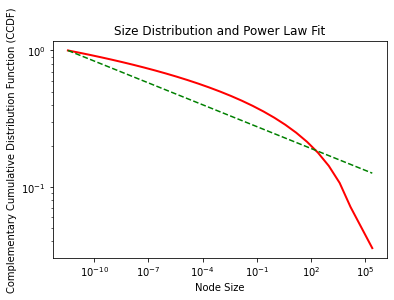

In [14]:
quard1 = split_weld_simulate(0.554,0.3,5)
size_distribution = find_size(quard1.root)
check_power_law_distribution(size_distribution)

p_value:  1.3652574083160669e-08
The size distribution is not a good fit for a power law distribution.


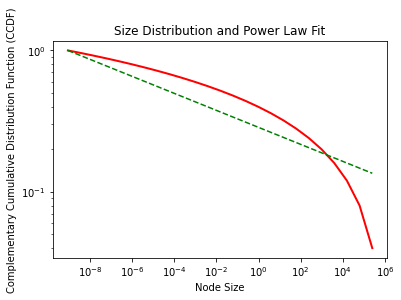

In [16]:
quard2 = split_weld_simulate(0.342,0.3,5)
size_distribution = find_size(quard2.root)
check_power_law_distribution(size_distribution)

p_value:  1.3652574083160669e-08
The size distribution is not a good fit for a power law distribution.


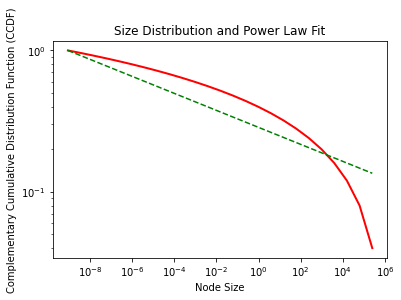

In [18]:
quard3 = split_weld_simulate(0.342,0.3,10)
size_distribution = find_size(quard3.root)
check_power_law_distribution(size_distribution)

## Model with size dependency of fracture (constant fracture and weld rate)
### 1. constant fracture and weld rate
### 2. choose fracture node based on size, random choose weld node

In [32]:
class Python_Switch_Size:
    def behave(self, num, quard):
        default = "Error input: input should be integer from 0 to 2"
        self.quard = quard
        return getattr(self, 'case_' + str(num), lambda: default)()
    
    def case_0(self):
        # nothing happen
        return 

    def case_1(self):
        # divde
        children = self.quard.leaf_list
        weights1 = [i.width for i in children]
        self.quard.subdivide(children.index(random.choices(children, weights1)[0]))

    
    def case_2(self):
        if len(self.quard.parent_list) == 1 or len(self.quard.parent_list) == 0:
            return
        # weld
        index = random.randint(0,len(self.quard.parent_list)-1)
        self.quard.weld(index)
#         parents = self.quard.parent_list
#         weights2 = [1/(i.width) for i in parents]
#         self.quard.weld(parents.index(random.choices(parents, weights2)[0]))

In [53]:
# 0: nothing happen
# 1: fracture
# 2: weld
def split_weld_simulate_size(spilt_rate, weld_rate, second):
    quard_example = QTree()
    if spilt_rate + weld_rate > 1:
        print("Error: invalid input, possibility larger than 1")
    nothing_rate = 1 - spilt_rate - weld_rate
    population = [0,1,2]
    weights = [nothing_rate, spilt_rate, weld_rate]
    for i in range(int(10000*second)):
        num = random.choices(population, weights)[0]
        switch = Python_Switch_Size()
        switch.behave(num, quard_example)
    size_distribution = find_size(quard_example.root)
    plot_size_distribution(size_distribution)
    quard_example.graph()
    return quard_example

sizes:  [0.95367431640625, 3.814697265625, 15.2587890625, 61.03515625, 244.140625, 976.5625]
counts:  [32, 600, 3360, 5994, 2102, 69]


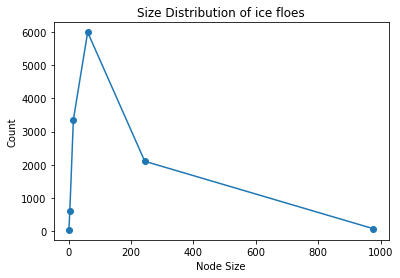

Number of segments: 12157
Minimum segment area: 0.954 units


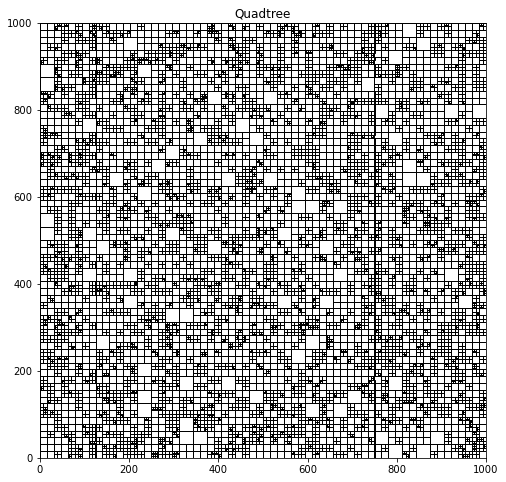

p_value:  0.3903644495299753
The size distribution is a good fit for a power law distribution.


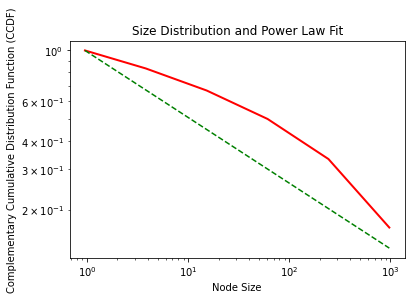

In [34]:
quard_size1 = split_weld_simulate_size(0.342,0.3,10)
size_distribution = find_size(quard_size1.root)
check_power_law_distribution(size_distribution)

sizes:  [0.95367431640625, 3.814697265625, 15.2587890625, 61.03515625, 244.140625, 976.5625, 3906.25]
counts:  [4, 131, 995, 2883, 2267, 257, 1]


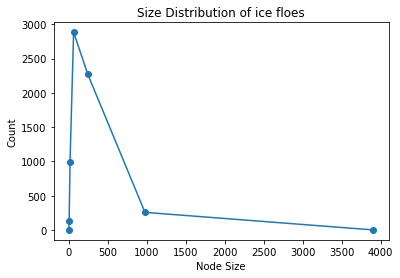

Number of segments: 6538
Minimum segment area: 0.954 units


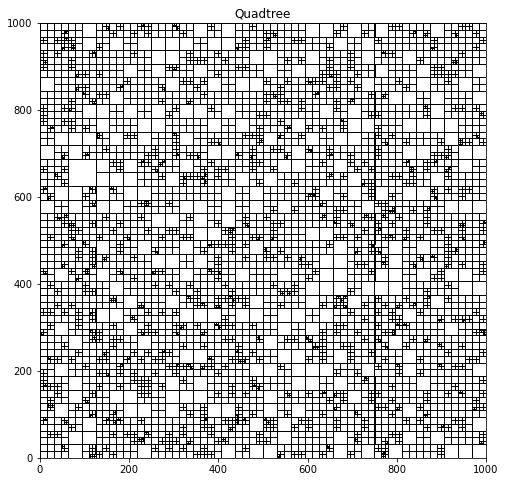

p_value:  0.2402815811574991
The size distribution is a good fit for a power law distribution.


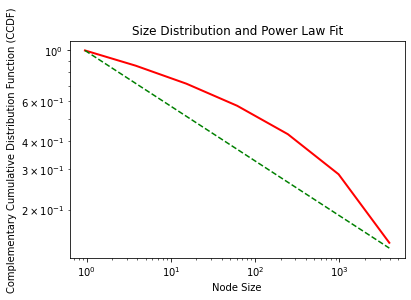

In [35]:
quard_size2 = split_weld_simulate_size(0.342,0.3,5)
size_distribution = find_size(quard_size2.root)
check_power_law_distribution(size_distribution)

sizes:  [0.2384185791015625, 0.95367431640625, 3.814697265625, 15.2587890625, 61.03515625, 244.140625, 976.5625]
counts:  [148, 1511, 6873, 12789, 7957, 1130, 16]


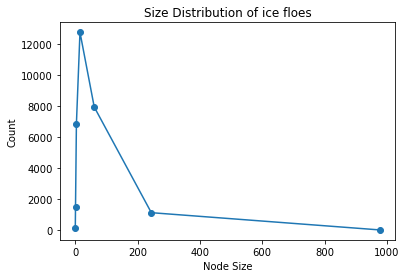

Number of segments: 30424
Minimum segment area: 0.238 units


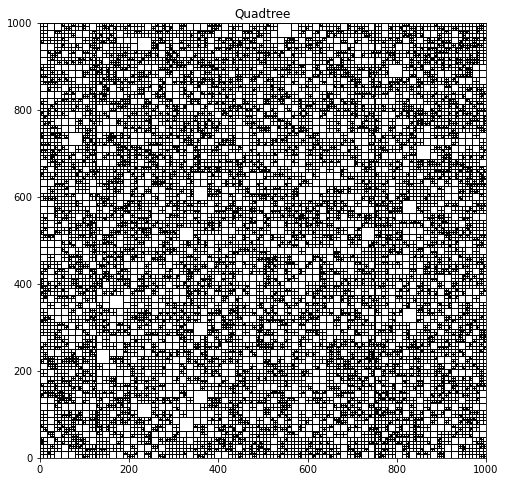

p_value:  0.24028158115749865
The size distribution is a good fit for a power law distribution.


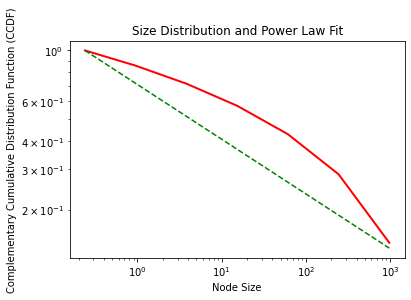

In [36]:
quard_size3 = split_weld_simulate_size(0.5,0.3,5)
size_distribution = find_size(quard_size3.root)
check_power_law_distribution(size_distribution)

sizes:  [0.014901161193847656, 0.059604644775390625, 0.2384185791015625, 0.95367431640625, 3.814697265625, 15.2587890625, 61.03515625, 244.140625, 976.5625]
counts:  [4, 115, 1235, 7988, 21744, 21633, 7179, 553, 6]


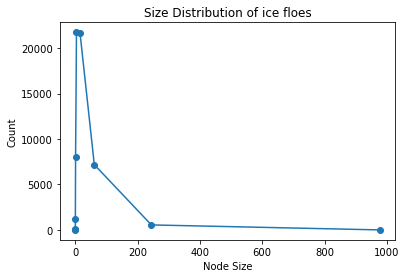

Number of segments: 60457
Minimum segment area: 0.015 units


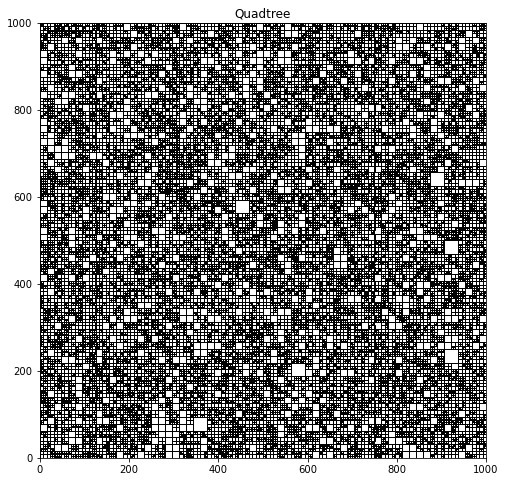

p_value:  0.07161732418762495
The size distribution is a good fit for a power law distribution.


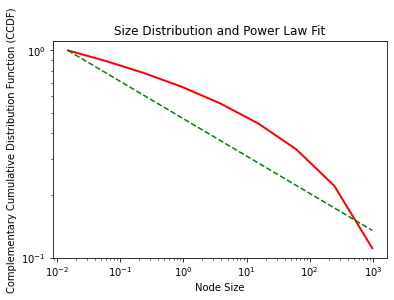

In [37]:
quard_size4 = split_weld_simulate_size(0.5,0.1,5)
size_distribution = find_size(quard_size4.root)
check_power_law_distribution(size_distribution)

sizes:  [244.140625, 976.5625, 3906.25, 15625.0, 62500.0]
counts:  [4, 19, 71, 21, 6]


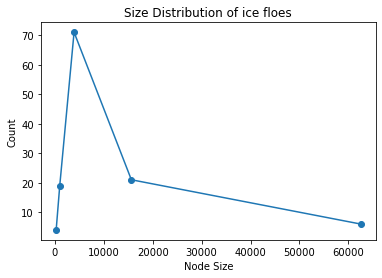

Number of segments: 121
Minimum segment area: 244.141 units


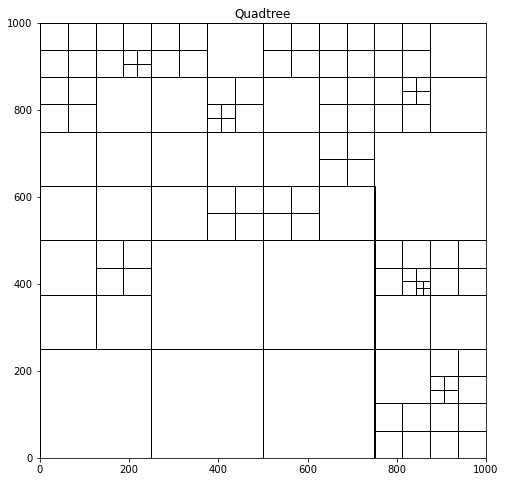

p_value:  0.5780698778819777
The size distribution is a good fit for a power law distribution.


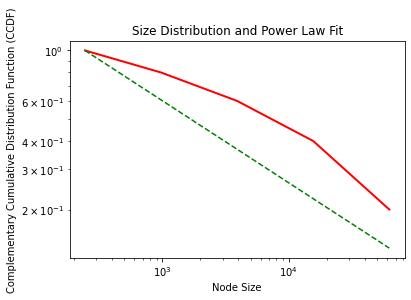

In [54]:
quard_size5 = split_weld_simulate_size(0.5,0.1,0.01)
size_distribution = find_size(quard_size5.root)
check_power_law_distribution(size_distribution)

## Simulation based on the leaves number and parents number
### 1. P(fracture) = 1 - P(weld), P(weld) = # of parents/ # of leaves
### 2. Random choice of node to fracture and weld

In [42]:
def split_weld_simulate_number(second):
    quard_example = QTree()
    weld_rate = len(quard_example.parent_list)/len(quard_example.leaf_list)
    spilt_rate = 1 - weld_rate
    population = [1,2]
    weights = [spilt_rate, weld_rate]
    for i in range(10000*second):
        weld_rate = len(quard_example.parent_list)/len(quard_example.leaf_list)
        spilt_rate = 1 - weld_rate
        # 1: fracture, 2: weld
        population = [1,2]
        # P(fracture) = 1 - P(weld)
        # P(weld) = # of parents/ # of leaves
        weights = [spilt_rate, weld_rate]
        num = random.choices(population, weights)[0]
        switch = Python_Switch()
        switch.behave(num, quard_example)
    size_distribution = find_size(quard_example.root)
    plot_size_distribution(size_distribution)
    quard_example.graph()
    return quard_example

sizes:  [8.673617379884035e-13, 3.469446951953614e-12, 1.3877787807814457e-11, 5.551115123125783e-11, 2.220446049250313e-10, 8.881784197001252e-10, 3.552713678800501e-09, 1.4210854715202004e-08, 5.6843418860808015e-08, 2.2737367544323206e-07, 9.094947017729282e-07, 3.637978807091713e-06, 1.4551915228366852e-05, 5.820766091346741e-05, 0.00023283064365386963, 0.0009313225746154785, 0.003725290298461914, 0.014901161193847656, 0.059604644775390625, 0.2384185791015625, 0.95367431640625, 3.814697265625, 15.2587890625, 61.03515625, 244.140625, 976.5625, 3906.25, 15625.0]
counts:  [4, 15, 20, 66, 126, 228, 534, 1002, 1616, 2356, 3492, 4662, 6252, 7768, 9430, 10945, 11431, 11517, 10997, 9422, 7403, 5421, 3029, 1541, 631, 239, 53, 15]


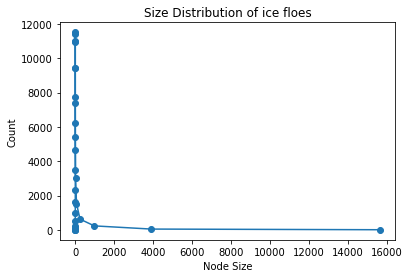

Number of segments: 110215
Minimum segment area: 0.000 units


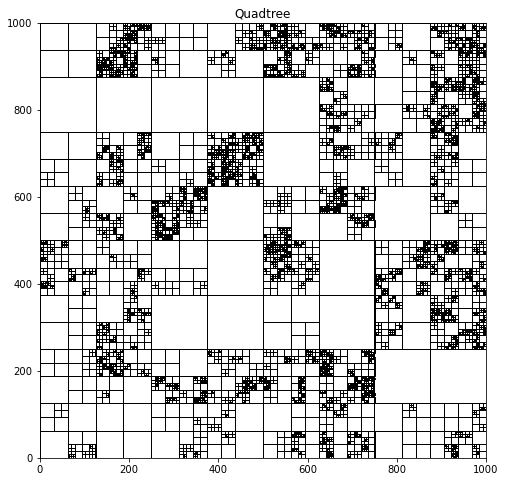

p_value:  4.2030118433376065e-10
The size distribution is not a good fit for a power law distribution.


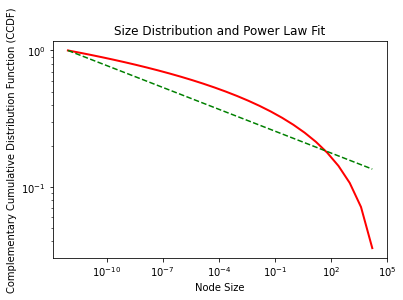

In [45]:
quard_num1 = split_weld_simulate_number(5)
size_distribution = find_size(quard_num1.root)
check_power_law_distribution(size_distribution)

## Simulation based on the leaves number and parents number, and size
### 1. P(fracture) = 1 - P(weld), P(weld) = # of parents/ # of leaves
### 2. choose fracture node based on size, random choose weld node

In [50]:
# 0: nothing happen
# 1: fracture
# 2: weld
def split_weld_simulate_number_size(second):
    quard_example = QTree()
    weld_rate = len(quard_example.parent_list)/len(quard_example.leaf_list)
    spilt_rate = 1 - weld_rate
    population = [1,2]
    weights = [spilt_rate, weld_rate]
    for i in range(int(10000*second)):
        # calculate the weld rate and fracture rate each time
        # based on the number of leaves and parents
        weld_rate = len(quard_example.parent_list)/len(quard_example.leaf_list)
        spilt_rate = 1 - weld_rate
        population = [1,2]
        weights = [spilt_rate, weld_rate]
        num = random.choices(population, weights)[0]
        switch = Python_Switch_Size()
        switch.behave(num, quard_example)
    size_distribution = find_size(quard_example.root)
    plot_size_distribution(size_distribution)
    quard_example.graph()
    return quard_example

sizes:  [0.014901161193847656, 0.059604644775390625, 0.2384185791015625, 0.95367431640625, 3.814697265625, 15.2587890625, 61.03515625, 244.140625, 976.5625]
counts:  [12, 461, 4996, 23434, 42634, 28301, 5402, 210, 1]


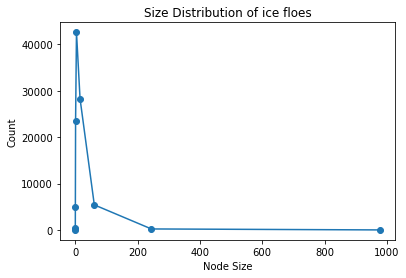

Number of segments: 105451
Minimum segment area: 0.015 units


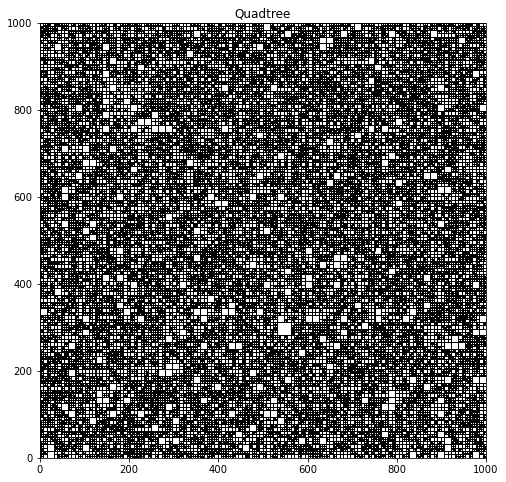

p_value:  0.07161732418762495
The size distribution is a good fit for a power law distribution.


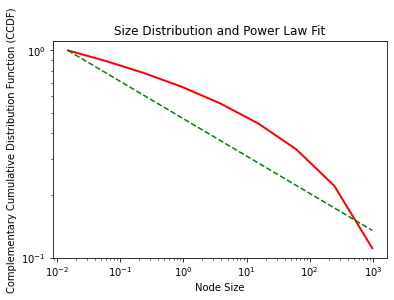

In [47]:
quard_num_size1 = split_weld_simulate_number_size(5)
size_distribution = find_size(quard_num_size1.root)
check_power_law_distribution(size_distribution)

sizes:  [3.814697265625, 15.2587890625, 61.03515625, 244.140625, 976.5625, 3906.25, 15625.0]
counts:  [8, 126, 540, 833, 444, 76, 2]


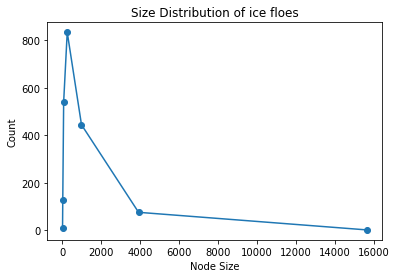

Number of segments: 2029
Minimum segment area: 3.815 units


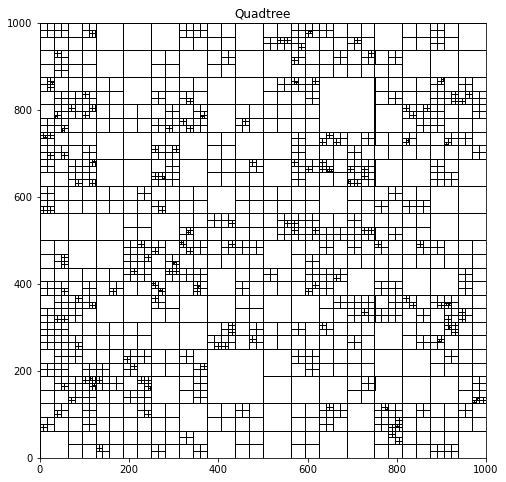

p_value:  0.2402815811574991
The size distribution is a good fit for a power law distribution.


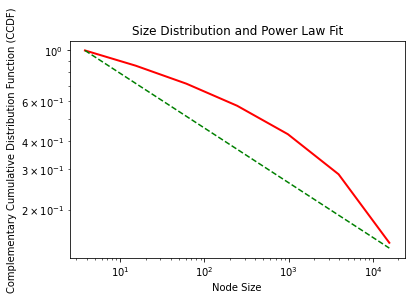

In [52]:
quard_num_size2 = split_weld_simulate_number_size(0.1)
size_distribution = find_size(quard_num_size2.root)
check_power_law_distribution(size_distribution)